In [1]:
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd

In [2]:
df = pd.read_csv('../input/animal-clef-2025/metadata.csv')
df.tail()

,image_id,identity,path,date,orientation,species,split,dataset
15204,15204,NaN,images/SeaTurtleID2022/query/images/fecd2dfed0...,2024-06-07,NaN,loggerhead turtle,query,SeaTurtleID2022
15205,15205,NaN,images/SeaTurtleID2022/query/images/ff1a0c812b...,2023-06-28,NaN,loggerhead turtle,query,SeaTurtleID2022
15206,15206,NaN,images/SeaTurtleID2022/query/images/ff22f1cfa6...,2024-06-09,NaN,loggerhead turtle,query,SeaTurtleID2022
15207,15207,NaN,images/SeaTurtleID2022/query/images/ff5d5116d1...,2023-06-21,NaN,loggerhead turtle,query,SeaTurtleID2022
15208,15208,NaN,images/SeaTurtleID2022/query/images/ff7f522363...,2023-06-13,NaN,loggerhead turtle,query,SeaTurtleID2022


In [3]:
data_dirs = {    
    "SeaTurtlesD": "/kaggle/input/animal-clef-2025/images/SeaTurtleID2022/database/turtles-data/data/images/t001",
    "SeaTurtlesQ": "/kaggle/input/animal-clef-2025/images/SeaTurtleID2022/query/images",
    "LynxsD": "/kaggle/input/animal-clef-2025/images/LynxID2025/database",
    "LynxsQ": "/kaggle/input/animal-clef-2025/images/LynxID2025/query",
    "SalamandersD": "/kaggle/input/animal-clef-2025/images/SalamanderID2025/database/images",
    "SalamandersQ": "/kaggle/input/animal-clef-2025/images/SalamanderID2025/query/images"
        
}

✅ Directory found: /kaggle/input/animal-clef-2025/images/SeaTurtleID2022/database/turtles-data/data/images/t001 (SeaTurtlesD)
✅ Directory found: /kaggle/input/animal-clef-2025/images/SeaTurtleID2022/query/images (SeaTurtlesQ)
✅ Directory found: /kaggle/input/animal-clef-2025/images/LynxID2025/database (LynxsD)
✅ Directory found: /kaggle/input/animal-clef-2025/images/LynxID2025/query (LynxsQ)
✅ Directory found: /kaggle/input/animal-clef-2025/images/SalamanderID2025/database/images (SalamandersD)
✅ Directory found: /kaggle/input/animal-clef-2025/images/SalamanderID2025/query/images (SalamandersQ)


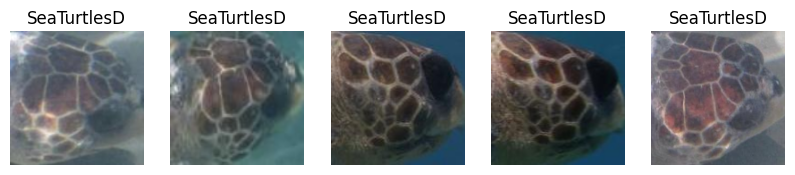

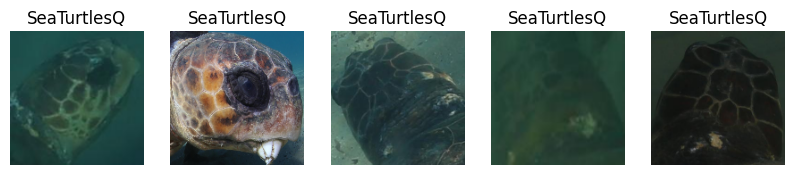

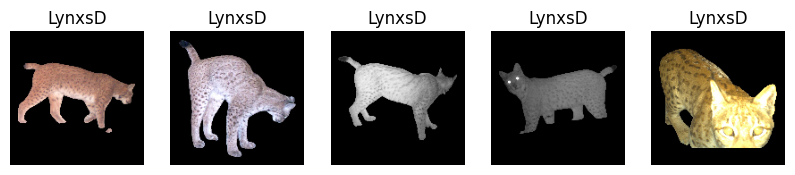

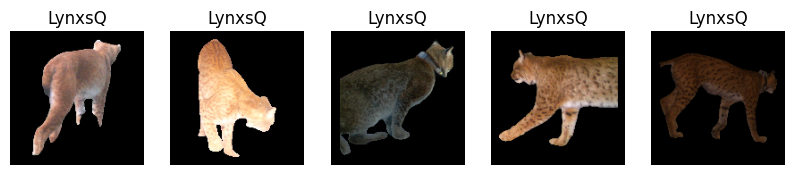

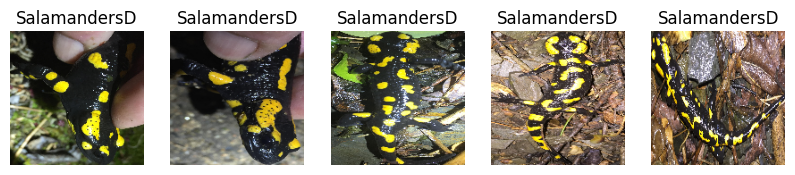

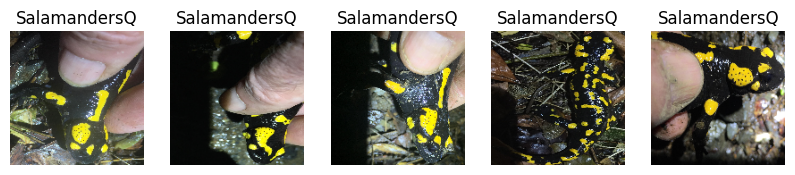

In [4]:
import os
import cv2
import matplotlib.pyplot as plt

# Define your data directories (Update with actual paths)
data_dirs = {    
    "SeaTurtlesD": "/kaggle/input/animal-clef-2025/images/SeaTurtleID2022/database/turtles-data/data/images/t001",
    "SeaTurtlesQ": "/kaggle/input/animal-clef-2025/images/SeaTurtleID2022/query/images",
    "LynxsD": "/kaggle/input/animal-clef-2025/images/LynxID2025/database",
    "LynxsQ": "/kaggle/input/animal-clef-2025/images/LynxID2025/query",
    "SalamandersD": "/kaggle/input/animal-clef-2025/images/SalamanderID2025/database/images",
    "SalamandersQ": "/kaggle/input/animal-clef-2025/images/SalamanderID2025/query/images"
}

# Check if directories exist
for label, path in data_dirs.items():
    if not os.path.exists(path):
        print(f"⚠ Warning: Directory {path} does not exist for {label}.")
    else:
        print(f"✅ Directory found: {path} ({label})")

def show_sample_images():
    valid_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')  # Add more formats if needed

    for label, dir_path in data_dirs.items():
        if not os.path.exists(dir_path):
            print(f"⚠ Skipping {label}: Directory does not exist.")
            continue

        # Load images
        sample_images = []
        for root, _, files in os.walk(dir_path):
            for img_name in files:
                img_path = os.path.join(root, img_name)
                if img_path.lower().endswith(valid_formats):
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, (150, 150))
                        sample_images.append(img)
                    if len(sample_images) == 5:  # Stop after 5 images
                        break
            if len(sample_images) == 5:
                break

        # Plot images
        if sample_images:
            plt.figure(figsize=(10, 10))
            for i, img in enumerate(sample_images):
                plt.subplot(1, 5, i + 1)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.title(f"{label}")
            plt.show()
        else:
            print(f"⚠ No valid images found in {dir_path} for {label}.")

# Call the function to display images
show_sample_images()


In [5]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Directories for each bird category
data_dirs = {
    "SeaTurtlesD": "/kaggle/input/animal-clef-2025/images/SeaTurtleID2022/database/turtles-data/data/images/t001",
    "SeaTurtlesQ": "/kaggle/input/animal-clef-2025/images/SeaTurtleID2022/query/images",
    "LynxsD": "/kaggle/input/animal-clef-2025/images/LynxID2025/database",
    "LynxsQ": "/kaggle/input/animal-clef-2025/images/LynxID2025/query",
    "SalamandersD": "/kaggle/input/animal-clef-2025/images/SalamanderID2025/database/images",
    "SalamandersQ": "/kaggle/input/animal-clef-2025/images/SalamanderID2025/query/images"    
}

IMG_SIZE = 150
X, Y = [], []

In [6]:
# Function to load images and labels
def load_images():
    for label, dir_path in data_dirs.items():
        if not os.path.exists(dir_path):
            print(f"Warning: Directory {dir_path} does not exist.")
            continue

        for root, _, files in os.walk(dir_path):  # Walk through all subdirectories
            for img_name in tqdm(files):
                img_path = os.path.join(root, img_name)

                # Ensure it's a valid image file
                if not img_path.lower().endswith(('.JPG', '.jpg', '.jpeg')):
                    print(f"Skipping {img_path}, not a valid image file.")
                    continue

                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read {img_path}. Skipping.")
                    continue  # Skip unreadable images

                try:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    X.append(img)
                    Y.append(label)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

In [7]:
import os
import numpy as np
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Define your data directories (Update with actual paths)
data_dirs = {    
    "SeaTurtlesD": "/kaggle/input/animal-clef-2025/images/SeaTurtleID2022/database/turtles-data/data/images/t001",
    "SeaTurtlesQ": "/kaggle/input/animal-clef-2025/images/SeaTurtleID2022/query/images",
    "LynxsD": "/kaggle/input/animal-clef-2025/images/LynxID2025/database",
    "LynxsQ": "/kaggle/input/animal-clef-2025/images/LynxID2025/query",
    "SalamandersD": "/kaggle/input/animal-clef-2025/images/SalamanderID2025/database/images",
    "SalamandersQ": "/kaggle/input/animal-clef-2025/images/SalamanderID2025/query/images"
}

# Function to load images
def load_images():
    X = []  # Image data
    Y = []  # Labels

    valid_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')  # Supported formats

    for label, dir_path in data_dirs.items():
        if not os.path.exists(dir_path):
            print(f"⚠ Warning: Directory {dir_path} does not exist for {label}. Skipping...")
            continue

        # Read images from the directory
        for img_name in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img_name)
            if img_path.lower().endswith(valid_formats):
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (150, 150))  # Resize for consistency
                    X.append(img)
                    Y.append(label)  # Store label
    
    return X, Y

# Load the dataset
X, Y = load_images()

# Convert to numpy arrays
if len(X) == 0 or len(Y) == 0 or len(X) != len(Y):
    raise ValueError(f"Mismatch in dataset sizes: X={len(X)}, Y={len(Y)}")

X = np.array(X, dtype='float32') / 255.0  # Normalize images
Y = np.array([list(data_dirs.keys()).index(y) for y in Y], dtype='int32')  # Convert labels to indices

# Shuffle and split dataset
X, Y = shuffle(X, Y, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"✅ Dataset successfully loaded: Train={len(X_train)}, Test={len(X_test)}")


✅ Dataset successfully loaded: Train=5201, Test=1301


In [8]:


# Model building
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(data_dirs), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6121 - loss: 0.9124 - val_accuracy: 0.7426 - val_loss: 0.5677
Epoch 2/2
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7461 - loss: 0.5274 - val_accuracy: 0.7435 - val_loss: 0.6148


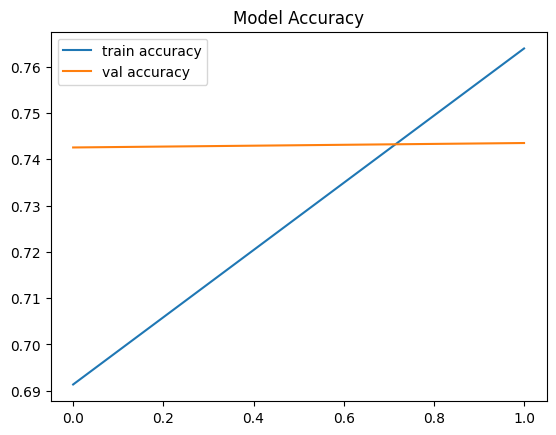

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7235 - loss: 0.6647
Test Accuracy: 71.87%


In [9]:


# Train the model
history = model.fit(X_train, Y_train, batch_size=32, epochs=2, validation_split=0.2) #Epochs=10

# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Evaluate on test data
loss, acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")